<a href="https://colab.research.google.com/github/kasvinatirumal/wdrp_wi25/blob/main/Call_and_Put_Option_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pricing Call and Put Options for Microsoft Stock using the Black-Scholes Model

In [24]:
pip install yahoo_fin

In [25]:
from yahoo_fin import options
import yfinance as yf
import pandas as pd
import math
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

## Obtaining Microsoft Stock Data from Yahoo Finance

In [26]:
# creates a Ticker object for Microsoft stock (MSFT)
msft = yf.Ticker("MSFT")

# gets expiration_dates for options
expiration_dates = msft.options
print(expiration_dates)

('2025-02-28', '2025-03-07', '2025-03-14', '2025-03-21', '2025-03-28', '2025-04-04', '2025-04-17', '2025-05-16', '2025-06-20', '2025-07-18', '2025-08-15', '2025-09-19', '2025-10-17', '2025-12-19', '2026-01-16', '2026-03-20', '2026-06-18', '2026-12-18', '2027-01-15', '2027-06-17', '2027-12-17')


## Pricing Call Options

In [27]:
# gets data for call options that expire on 2025-08-15
call_options = options.get_calls("MSFT", "2025-08-15")
print(call_options)

/usr/local/lib/python3.11/dist-packages/yahoo_fin/options.py:42: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(requests.get(site, headers=headers).text)


          Contract Name Last Trade Date (EST)  Strike  Last Price     Bid  \
0   MSFT250815C00200000    2/24/2025 12:00 PM     200      207.54  200.30   
1   MSFT250815C00210000   12/27/2024 11:15 AM     210      224.43  207.40   
2   MSFT250815C00225000   12/16/2024 12:13 AM     225      215.60  228.60   
3   MSFT250815C00230000      1/6/2025 3:43 PM     230      203.40    0.00   
4   MSFT250815C00235000      1/6/2025 3:50 PM     235      198.85    0.00   
..                  ...                   ...     ...         ...     ...   
77  MSFT250815C00610000      2/5/2025 9:37 AM     610        0.56    0.24   
78  MSFT250815C00615000     2/25/2025 2:25 PM     615        0.25    0.22   
79  MSFT250815C00620000     2/11/2025 9:30 AM     620        0.23    0.20   
80  MSFT250815C00640000     2/25/2025 9:48 AM     640        0.15    0.13   
81  MSFT250815C00660000    2/25/2025 12:35 PM     660        0.13    0.09   

       Ask  Change % Change Volume  Open Interest Implied Volatility  
0   

In [28]:
df1 = pd.DataFrame(call_options)
df1.to_csv('call_options.csv', index=False)

In [29]:
calls = df1.copy()
calls.head()

,Contract Name,Last Trade Date (EST),Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility
0,MSFT250815C00200000,2/24/2025 12:00 PM,200,207.54,200.3,203.40,0.0,0.00%,4,8,67.90%
1,MSFT250815C00210000,12/27/2024 11:15 AM,210,224.43,207.4,211.05,0.0,0.00%,15,15,106.72%
2,MSFT250815C00225000,12/16/2024 12:13 AM,225,215.60,228.6,231.55,0.0,0.00%,1,1,158.43%
3,MSFT250815C00230000,1/6/2025 3:43 PM,230,203.40,0.0,0.00,0.0,0.00%,15,33,0.00%
4,MSFT250815C00235000,1/6/2025 3:50 PM,235,198.85,0.0,0.00,0.0,0.00%,41,31,0.00%


In [30]:
calls.describe()

,Strike,Last Price,Bid,Ask,Change,Open Interest
count,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000
mean,426.890244,52.629756,43.775244,44.961585,-1.313049,354.000000
std,121.978647,65.689443,56.933876,57.746722,2.640848,660.509941
min,200.000000,0.130000,0.000000,0.000000,-17.330000,1.000000
25%,326.250000,1.620000,1.177500,1.362500,-1.575000,44.250000
50%,427.500000,17.760000,14.300000,16.350000,-0.170000,123.000000
75%,528.750000,92.310000,74.025000,75.475000,0.000000,414.750000
max,660.000000,224.430000,228.600000,231.550000,0.350000,4693.000000


In [31]:
calls["Implied Volatility"] = calls["Implied Volatility"].str[:-1].astype(float)
calls = calls[calls["Implied Volatility"] != 0]

We first calculate the price of a call option on Microsoft stock expiring on 2025-08-15, using the median strike price and volatility from the calls dataset. Before proceeding, we define the following variables:

- K: Strike price in US dollars
- S: Stock price in US dollars
- T: Time to expiration in number of years
- r: Risk-free rate (based on current yield on 6 month trasury bill)
- v: Volatility
- F: Price of option

In [32]:
strike_price = calls["Strike"].median()
imp_vol = calls["Implied Volatility"].median()
print(f"strike_price = {strike_price}, imp_vol ={imp_vol}")

strike_price = 432.5, imp_vol =28.345


In [33]:
S = 408.43	# closing Microsoft stock price on Feb 14
K = strike_price
T = 0.5 # 6 months
r = 0.0434 # current yield on 6 month treasury bill (4.34%)
v = imp_vol/100

## Formula for Call Options:
$$d_1 = \frac{1}{v \cdot \sqrt{T}} \cdot \left[ln\left(\frac{S}{K}\right) + \left(r + \frac{1}{2}v^2\right) \cdot T\right]$$

$$d_2 = d_1 - v \cdot \sqrt{T}$$

$$F =  S \cdot N[d_1] - e^{−rT} \cdot K \cdot N[d_2]$$

In [34]:
def calc_call_option_price(S, K, T, r, v):
  d1 = (math.log(S/K) + (r + 0.5 * v**2) * T) / (v * math.sqrt(T))
  d2 = d1 - v * math.sqrt(T)
  F = S * norm.cdf(d1) - math.exp(-r * T) * K * norm.cdf(d2)
  return F

In [35]:
calc_call_option_price(S, K, T, r, v)

26.319912180210878

Next, we compute the theoretical price for each option in the calls dataset and add it as a new column.

In [36]:
calls["Theoretical Price"] = calls.apply(
    lambda row: calc_call_option_price(S, row["Strike"], T, r, row["Implied Volatility"]/100),
    axis=1
)

Text(0.5, 1.0, 'Scatterplot of Implied Volatility vs Theoretical Call Option Prices')

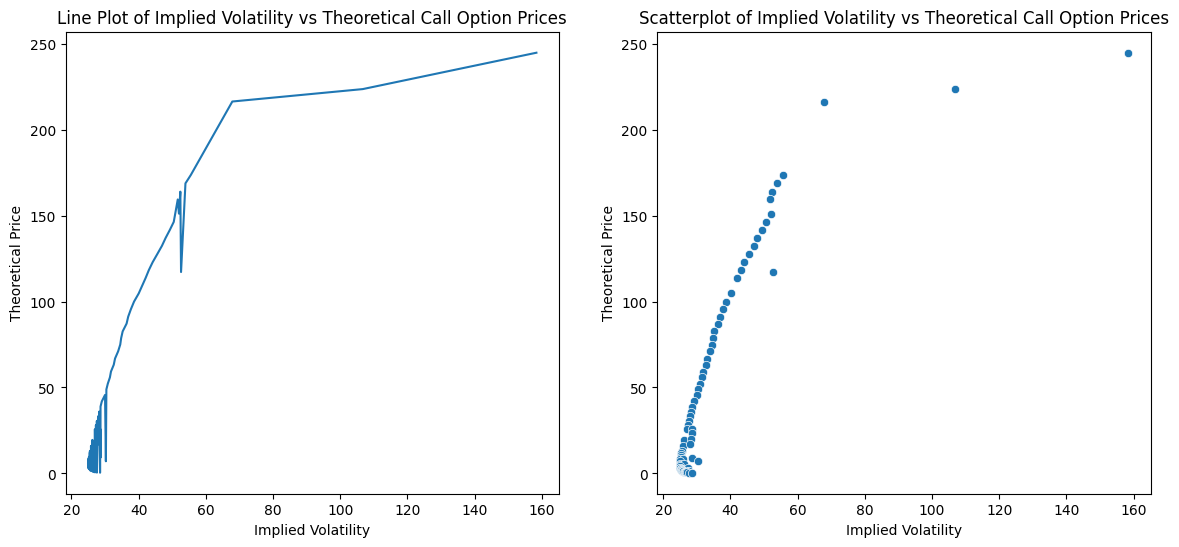

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.lineplot(x="Implied Volatility", y="Theoretical Price", data=calls, ax=axs[0])
axs[0].set_title("Line Plot of Implied Volatility vs Theoretical Call Option Prices")

sns.scatterplot(x="Implied Volatility", y="Theoretical Price", data=calls, ax=axs[1])
axs[1].set_title("Scatterplot of Implied Volatility vs Theoretical Call Option Prices")

<Axes: xlabel='Strike', ylabel='Implied Volatility'>

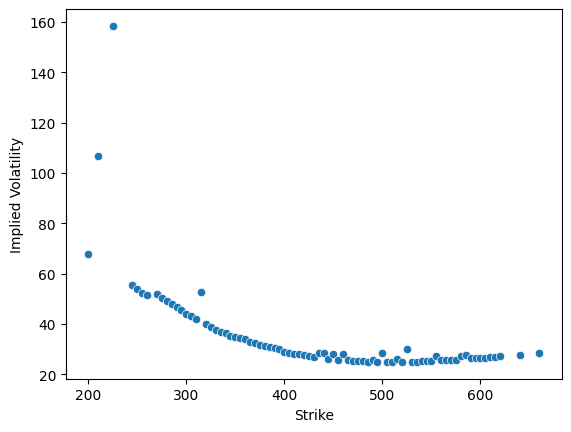

In [47]:
sns.scatterplot(x="Strike", y="Implied Volatility", data=calls)

## Pricing Put Options

In [39]:
put_options = options.get_puts("MSFT", "2025-08-15")

/usr/local/lib/python3.11/dist-packages/yahoo_fin/options.py:42: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(requests.get(site, headers=headers).text)


In [40]:
df2 = pd.DataFrame(put_options)
df2.to_csv('put_options.csv', index=False)

In [41]:
puts = df2.copy()

In [42]:
puts["Implied Volatility"] = puts["Implied Volatility"].str[:-1].astype(float)
puts = puts[puts["Implied Volatility"] != 0]

## Formula for Put Options:
$$F = e^{−r(T −t)} \cdot K \cdot N[d_2] - S \cdot N[d_1]$$

In [43]:
def calc_put_option_price(S, K, T, r, v):
  d1 = (math.log(S/K) + (r + 0.5 * v**2) * T) / (v * math.sqrt(T))
  d2 = d1 - v * math.sqrt(T)
  F = math.exp(-r * T) * K * norm.cdf(-d2) - S * norm.cdf(-d1)
  return F

In [44]:
puts["Theoretical Price"] = puts.apply(
    lambda row: calc_put_option_price(S, row["Strike"], T, r, row["Implied Volatility"]/100),
    axis=1
)

Text(0.5, 1.0, 'Scatterplot of Implied Volatility vs Theoretical Put Option Prices')

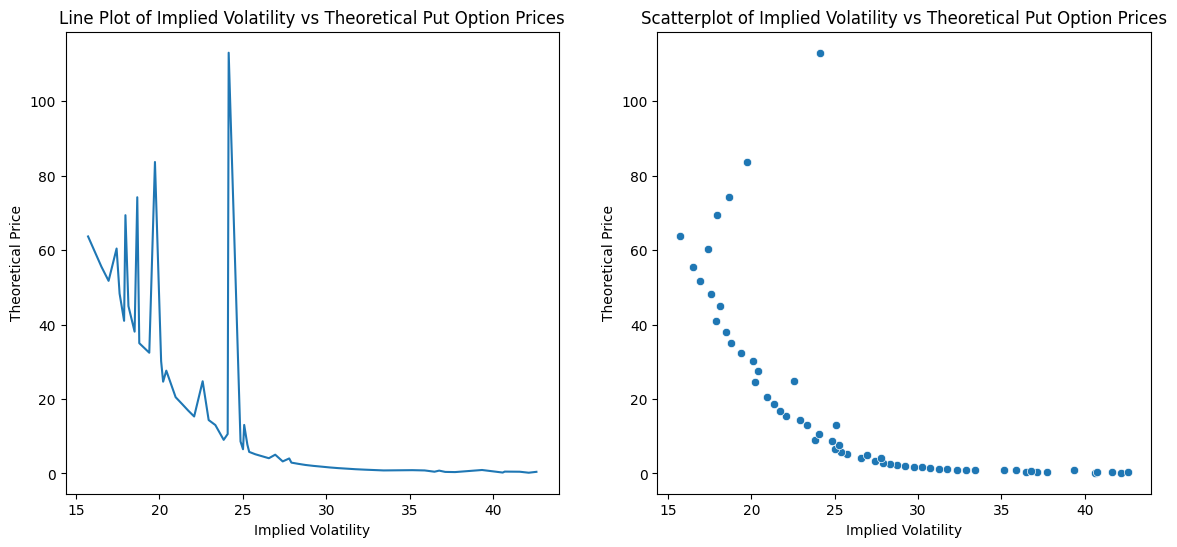

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.lineplot(x="Implied Volatility", y="Theoretical Price", data=puts, ax=axs[0])
axs[0].set_title("Line Plot of Implied Volatility vs Theoretical Put Option Prices")

sns.scatterplot(x="Implied Volatility", y="Theoretical Price", data=puts, ax=axs[1])
axs[1].set_title("Scatterplot of Implied Volatility vs Theoretical Put Option Prices")

## Further Exploration
1. Does call-put parity hold in real-world markets, and what factors may cause this theoretical model to not hold?
2. Does the volatility smile exist in real-world markets, and how does its curviness change with different times to expiration? Under what market conditions is the volatility smile most pronounced?
3. How would the stocks be priced using risk-neutral valuation, and how does it differ from its actual market price?
4. What is the estimated drift of the stock, and how does it compare to the risk-free interest rate?













